In [2]:
# Adapted from https://pytorch.org/rl/0.4/tutorials/multiagent_ppo.html

####################################
# Imports
####################################
import numpy as np
import torch

from tensordict import TensorDictBase

from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import multiprocessing

from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

from torchrl.envs import RewardSum, TransformedEnv
from torchrl.envs.libs.vmas import VmasEnv
from torchrl.envs.utils import check_env_specs

from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal

from torchrl.objectives import ClipPPOLoss, ValueEstimators

from tensordict.nn import TensorDictModule, TensorDictSequential

from torchrl.record import CSVLogger, PixelRenderTransform, VideoRecorder

from matplotlib import pyplot as plt
import copy

In [3]:
####################################
# Constants and Hyperparams
####################################

# Devices
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")
print(device)

# Seed
SEED = 0
torch.manual_seed(SEED)

# Sampling
n_iters = 100  # Number of sampling and training iterations
frames_per_batch = 6_000  # Number of team frames collected per training iteration
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 30  # Number of optimization steps per training iteration
minibatch_size = 400  # Size of the mini-batches in each optimization step
lr = 3e-4  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients

# PPO
clip_epsilon = 0.2  # clip value for PPO loss
gamma = 0.99  # discount factor
lmbda = 0.9  # lambda for generalised advantage estimation
entropy_eps = 1e-4  # coefficient of the entropy term in the PPO loss

####################################
# Environment Setup
####################################
SIM_MAX_STEPS = 100  # Environment steps before truncated

N_PURSUERS = 3
N_EVADERS = 1
N_OBSTACLES = 0

# Use VMAS env: offers ~2x speed
base_env = VmasEnv(
    scenario="simple_tag",
    num_envs= frames_per_batch // SIM_MAX_STEPS, # Number of vectorized environments. frames_per_batch collection are divided evenly.
    continuous_actions=True,
    max_steps=SIM_MAX_STEPS,
    device=device,
    seed=SEED,
    # Scenario specific
    num_good_agents=N_EVADERS,
    num_adversaries=N_PURSUERS,
    num_landmarks=N_OBSTACLES,
)

cpu


In [4]:
# Transform environment to accumulate rewards per team
env = TransformedEnv(
    base_env,
    RewardSum(
        in_keys=base_env.reward_keys,
        reset_keys=["_reset"] * len(base_env.group_map.keys()),
    ),
)

check_env_specs(env) # Perform rollout to ensure Transform performed correctly

# View Example Rollout 

# n_rollout_steps = 5
# rollout = env.rollout(n_rollout_steps)
# print(f"rollout of {n_rollout_steps} steps:", rollout)
# print("Shape of the rollout TensorDict:", rollout.batch_size)

2025-04-03 17:28:12,700 [torchrl][INFO] check_env_specs succeeded!


In [5]:
####################################
# Actor: Policy
####################################

# MultiAgentMLP to map observations -> actions
policy_modules = {}
for group, agents in env.group_map.items():
    share_parameters_policy = True  # Agents are behaviorally homogenous

    policy_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec[group, "observation"].shape[-1],  # num inputs = observation space of the group
        n_agent_outputs=env.full_action_spec[group, "action"].shape[-1] * 2,  # num outputs = 2 * action space of the group 
        n_agents=len(agents),  # number of agents in the group
        centralised=False,  # decentralized policies (agents act on local observations only)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    )

    policy_net = torch.nn.Sequential(policy_net, NormalParamExtractor()) # Extractor separates last dimension into two outputs: loc and scale

    # Wrap the NN in a TensorDictModule. 
    # The module reads in_keys from a tensordict, feeds them into the NN, and writes output in-place at out_keys
    policy_module = TensorDictModule(
        policy_net,
        in_keys=[(group, "observation")],
        out_keys=[(group, "loc"), (group, "scale")],
    ) 

    policy_modules[group] = policy_module


# ProbabilisticActor to build a TanhDelta out of action parameters. 
policies = {}
for group, _agents in env.group_map.items():
    policy = ProbabilisticActor(
        module=policy_modules[group],
        spec=env.full_action_spec[group, "action"],
        in_keys=[(group, "loc"), (group, "scale")],
        out_keys=[(group, "action")],
        distribution_class=TanhNormal,
        distribution_kwargs={
            "low": env.full_action_spec[group, "action"].space.low, # min action: -1 
            "high": env.full_action_spec[group, "action"].space.high, # max action: +1
        },
        return_log_prob=True, # Need log-prob for PPO loss
        log_prob_key=(group, "sample_log_prob"),
    )
    policies[group] = policy

In [6]:
####################################
# Critic: Value
####################################

# MultiAgentMLP to map observations & actions -> values
critics = {} 
for group, agents in env.group_map.items():
    share_parameters_critic = True  # Centralized training 
    
    critic_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec[group, "observation"].shape[-1], # num inputs = obs space
        n_agent_outputs=1,  # num output: 1 value per agent
        n_agents=len(agents),
        centralised=True, # If False, we create IPPO (decentralized critic, just like decentralized agent policies)
        share_params=share_parameters_critic,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    )

    # Wrap the NN in a TensorDictModule.
    # Read in obs-action pairs, output the value in-place.
    critic_module = TensorDictModule(
        critic_net,
        in_keys=[(group, "observation")],
        out_keys=[(group, "state_value")],
    )

    critics[group] = critic_module

In [7]:
module = torch.nn.Linear(3, 4)
normal_params = NormalParamExtractor()
tensor = torch.randn(3)
print(tensor)
out = module(tensor)
print(out)
loc, scale = normal_params(out)
print(loc)
print(scale)

tensor([0.7051, 1.3738, 1.6448])
tensor([ 0.2335,  0.5116, -0.1462,  0.1987], grad_fn=<ViewBackward0>)
tensor([0.2335, 0.5116], grad_fn=<SplitBackward0>)
tensor([0.9107, 1.1294], grad_fn=<ClampMinBackward0>)


In [8]:
for group, _agents in env.group_map.items():
    reset_td = env.reset() 

    # This code shows that after calling policy and critic, the outputs we want (loc, scale, sample_log_prob, etc) are
    # appended in the TensorDict! We can now retrieve them. 
    # print("**** Policy and Critic for group:", group, "****")

    # print("Running policy:", policies[group](reset_td))
    # print("====================")
    # print("Running value:", critics[group]((reset_td)))

In [9]:
####################################
# Data Collector
####################################
# Run group policies simultaneously by putting them in sequence.
group_exploration_policy = TensorDictSequential(*policies.values())

# Data collectors reset the environment, and perform rollout until done state is reached. 
# Repeats until total_frames are collected. 
data_collector = SyncDataCollector(
    env,
    group_exploration_policy,
    device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

####################################
# Replay Buffer
####################################
replay_buffers = {}

for group, _agents in env.group_map.items():
    replay_buffer = ReplayBuffer(
        storage=LazyTensorStorage(frames_per_batch, device=device),  # Store the frames_per_batch collected from each iteration. 
        sampler=SamplerWithoutReplacement(),
        batch_size=minibatch_size, # Sample minibatches of this size
    )
    replay_buffers[group] = replay_buffer

####################################
# Loss Functions
####################################
losses = {}
GAEs = {}
for group, _agents in env.group_map.items():
    # Use ClipPPOLoss class to hide away PPO math and control flow. 
    loss_module = ClipPPOLoss(
        actor_network=policies[group],
        critic_network=critics[group],
        clip_epsilon=clip_epsilon,
        entropy_coef=entropy_eps,
        normalize_advantage=False, # Necessary to avoid normalizing across agent dimension TODO: changed to true
    )

    loss_module.set_keys(
        reward=(group, "reward"),
        action=(group, "action"),
        sample_log_prob=(group, "sample_log_prob"),
        value=(group, "state_value"),
        done=(group, "done"),
        terminated=(group, "terminated"),
    )

    loss_module.make_value_estimator(ValueEstimators.GAE, gamma=gamma, lmbda=lmbda) # Create General Advantage Estimator (GAE)

    losses[group] = loss_module # ClipPPOLoss object 
    GAEs[group] = loss_module.value_estimator # Retrieves from ClipPPOLoss the GAE object

optimisers = {} # Adam Optimiser
for group, loss in losses.items():
    optimisers[group] = torch.optim.Adam(loss.parameters(), lr)

In [10]:
####################################
# Training Helper Function
####################################
def process_batch(batch: TensorDictBase) -> TensorDictBase:
    """
    If (group, "terminated") and (group, "done") keys don't exist, create them.
    This is needed to maintain same batch shape for loss calculation. 
    """
    for group in env.group_map.keys():
        keys = list(batch.keys(True, True))
        group_shape = batch.get_item_shape(group)

        nested_done_key = ("next", group, "done")
        if nested_done_key not in keys:
            batch.set(
                nested_done_key,
                batch.get(("next", "done")).unsqueeze(-1).expand((*group_shape, 1)),
            )

        nested_terminated_key = ("next", group, "terminated")
        if nested_terminated_key not in keys:
            batch.set(
                nested_terminated_key,
                batch.get(("next", "terminated"))
                .unsqueeze(-1)
                .expand((*group_shape, 1)),
            )
    return batch

In [11]:
####################################
# Training Loop
####################################
ITER_STOP_TRAIN_EVADERS = n_iters // 2
N_OPTIMIZER_STEPS = 100  # Number of optimization steps per training iteration

episode_reward_mean_map = {group: [] for group in env.group_map.keys()}
curr_groups = copy.deepcopy(env.group_map)

# Training/collection iterations
for i, batch in enumerate(data_collector):
    print("Iteration:", i+1)
    batch = process_batch(batch)  # Expand 'done' keys if needed (its needed lol)

    # Train each group
    for group in curr_groups.keys():
        # Exclude data from other groups
        group_batch = batch.exclude(*[key for _group in env.group_map.keys()
                                      if _group != group
                                      for key in [_group, ("next", _group)]]) 
        
        # Compute Advantage
        with torch.no_grad():
            GAEs[group](group_batch, 
                        params=losses[group].critic_network_params, 
                        target_params=losses[group].target_critic_network_params,)
            
        group_batch = group_batch.reshape(-1)  # Make batch one-dimensional
        replay_buffers[group].extend(group_batch) # Add batch to Replay Buffer
        
        # Loop over epochs
        for _ in range(num_epochs):
            # Loop over minibatches to compute losses
            for _ in range(frames_per_batch // minibatch_size):
                subdata = replay_buffers[group].sample() # sample from Replay Buffer
                loss_vals = losses[group](subdata) # Generates loss for every sample in the batch (has shape BATCH_SIZE)

                final_loss = loss_vals["loss_objective"] + loss_vals["loss_critic"] + 0.5 * loss_vals["loss_entropy"]

                optimisers[group].zero_grad()

                # Backpropagate + Optimize
                final_loss.backward()

                # Optional: clip huge gradients
                torch.nn.utils.clip_grad_norm_(losses[group].parameters(), max_grad_norm) 

                optimisers[group].step() # TODO: THIS IS CAUSING ISSUES
        
        
        data_collector.update_policy_weights_() # TODO: check with and without this?

    # Logging
    for group in env.group_map.keys():
        episode_reward_mean = (
            batch.get(("next", group, "episode_reward"))[
                batch.get(("next", group, "done"))
            ]
            .mean()
            .item()
        )
        episode_reward_mean_map[group].append(episode_reward_mean)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47


AssertionError: 

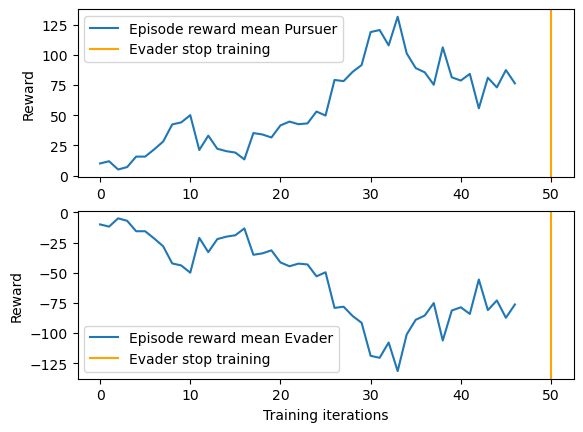

In [12]:
####################################
# Plot Results
####################################

fig, axs = plt.subplots(2, 1)
for i, group in enumerate(env.group_map.keys()):
    if group == "adversary":
        group_name = "Pursuer"
    else:
        group_name = "Evader"

    axs[i].plot(episode_reward_mean_map[group], label=f"Episode reward mean {group_name}")
    axs[i].set_ylabel("Reward")
    axs[i].axvline(
        x=ITER_STOP_TRAIN_EVADERS,
        label="Evader stop training",
        color="orange",
    )
    axs[i].legend()
axs[-1].set_xlabel("Training iterations")
plt.show()

In [ ]:
####################################
# Rollout and Render!
####################################

windows = False
folder_name = "MAPPO"
video_name = "MAPPO_failure"

if windows:
    saveLoc = "C:\\Users\\dfc49\\Desktop\\Research\\MPE_Testing\\Videos"
else:
    saveLoc = "/Users/dchang/Desktop/Princeton/Senior Year/Research/MPE_Testing"

video_logger = CSVLogger(folder_name, saveLoc, video_format="mp4")
env_with_render = TransformedEnv(env.base_env, env.transform.clone())
env_with_render = env_with_render.append_transform(
    PixelRenderTransform(
        out_keys=["pixels"],
        preproc=lambda x: x.copy(),
        as_non_tensor=True,
        mode="rgb_array", # must be this to record
    )
)
env_with_render = env_with_render.append_transform(VideoRecorder(logger=video_logger, tag=video_name))
print("Rendering rollout...")
env_with_render.rollout(100, policy=group_exploration_policy)

print("Saving the video...")
env_with_render.transform.dump()
print("Saved! Saved to ", saveLoc)

Rendering rollout...
Saving the video...
Saved! Saved to  /Users/dchang/Desktop/Princeton/Senior Year/Research/MPE_Testing
